# INCEPTION WITH BATCH NORM (MNIST)

**Import necessary packages and modules**

In [1]:
import os
import time
import datetime
import string
import random
import math
import json
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
from skimage.io import imread
from sklearn.metrics import accuracy_score
import progressbar
tf.reset_default_graph()
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

**Set random seed of tensorflow and numpy**

In [2]:
# np_rand_seed = random.randint(0,100)
# tf_rand_seed = random.randint(0,100)
np_seed = 56
tf_seed = 62
np.random.seed(np_seed)
print("numpy random seed: ",np_seed)
print("tensorflow random seed: ", tf_seed)

numpy random seed:  56
tensorflow random seed:  62


## 1. Extract paths and labels of train and test images

**Set directories**

In [3]:
input_dir = "../input/"
model_dir = "./model_files/"
submission_dir = "./submission_files/"

**Class to labels & label to class dictionaries**

**Extract paths and labels of train images**

In [4]:
train_ids = []
train_labels = []
for item in list(os.walk(input_dir+"training/"))[0][1]:
    for image in list(os.walk(input_dir+"training/"+str(item)+"/"))[0][2]:
        train_ids.append(input_dir+"training/"+str(item)+"/"+image)
        train_labels.append(item)
train_ids = np.array(train_ids)
train_labels = [int(train_label) for train_label in train_labels]
train_labels = np.array(train_labels)

**Extract paths and labels of test images**

In [5]:
test_ids = []
test_labels = []
for item in list(os.walk(input_dir+"testing/"))[0][1]:
    for image in list(os.walk(input_dir+"testing/"+str(item)+"/"))[0][2]:
        test_ids.append(input_dir+"testing/"+str(item)+"/"+image)
        test_labels.append(item)
test_ids = np.array(test_ids)
test_labels = [int(test_label) for test_label in test_labels]
test_labels = np.array(test_labels)

## 2. Input Functions

**Augmentation functions**

In [6]:
def rotate_image(img, angle = 20):    
    '''
    a function to rotate image by a given degree
    '''    
    # rotate image
    copy = img.copy()
    M_rotate = cv2.getRotationMatrix2D((14,14),angle,1)
    img_new = cv2.warpAffine(copy,M_rotate,(28,28))
    return img_new


def translate_horizontal(image, shift_horizontal = 5):
    '''
    A function to translate image horizontally by a shift
    '''
    # horizontally shift image
    img = image.copy()
    
    shift_vertical = 0
    M_translate = np.float32([[1,0,shift_horizontal],[0,1,shift_vertical]])
    img_new = cv2.warpAffine(img,M_translate,(28,28))
    
    return img_new.reshape(28,28).astype(np.float32)


def translate_vertical(image, shift_vertical = 5):
    
    '''a function to translate image vertically by a shift'''
    
    # vertically shift image
    img = image.copy()
    
    shift_horizontal = 0;
    if shift_vertical<0:
        image_slice = img[shift_vertical:,:].copy()
    if shift_vertical>0:
        image_slice = img[:shift_vertical,:].copy()
    M_translate = np.float32([[1,0,shift_horizontal],[0,1,shift_vertical]])
    img_new = cv2.warpAffine(img,M_translate,(28,28))
    
    return img_new.reshape(28,28).astype(np.float32)


def translate_positive_diagonal(image, shift_diagonal = 5):
    
    '''a function to translate image along positive diagonal'''
    
    # translate image along positive diagonal
    img = image.copy()
    
    if shift_diagonal<0:
        hor_slice = img[shift_diagonal:,:].copy()
        ver_slice = img[:,shift_diagonal:].copy()
    else:
        hor_slice = img[:shift_diagonal,:].copy()
        ver_slice = img[:,:shift_diagonal].copy()
    M_translate = np.float32([[1,0,shift_diagonal],[0,1,shift_diagonal]])
    img_new = cv2.warpAffine(img,M_translate,(28,28))
    
    return img_new.reshape(28,28).astype(np.float32)


def translate_negative_diagonal(image, shift_diagonal = 5):
    
    '''a function to translate image along negative diagonal'''
    
    # translate image along negative diagonal
    img = image.copy()
    
    if shift_diagonal<0:
        hor_slice = img[:-shift_diagonal,:].copy()
        ver_slice = img[:,shift_diagonal:].copy()
    if shift_diagonal>0:
        hor_slice = img[-shift_diagonal:,:].copy()
        ver_slice = img[:,:shift_diagonal].copy()
    M_translate = np.float32([[1,0,shift_diagonal],[0,1,-shift_diagonal]])
    img_new = cv2.warpAffine(img,M_translate,(28,28))
        
    return img_new.reshape(28,28).astype(np.float32)


def zoom(image, zoom_shift = 5):
    
    '''a function to zoom image'''
    
    # zoom image
    img = image.copy()
    
    # zoom in 
    if zoom_shift>0:
        # scale
        img_new = cv2.resize(img, (28+zoom_shift*2,28+zoom_shift*2)) 
        # crop
        img_new = img_new[zoom_shift:-zoom_shift,zoom_shift:-zoom_shift] 
    # zoom out
    else:
        zoom_shift *=-1        
        # scale
        img_new = cv2.resize(img, (28-zoom_shift*2,28-zoom_shift*2)) 
        # zero padding
        img_new = cv2.copyMakeBorder(img_new,zoom_shift,zoom_shift,zoom_shift,zoom_shift,
                                     cv2.BORDER_CONSTANT,value=0.0) 
        
    return img_new.reshape(28,28).astype(np.float32)

**A funtion to generate batch of images and corresponding labels**

In [7]:
def generate_batch(indices, ids, labels, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES,
                   augmentation_percentage = 0.5, train_set = False, one_hot_encode = False):
    
    # extract the id based of train/test set
    batch_ids = ids[indices]
    
    # initialize numpy arrays to hold images and masks 
    X = np.zeros((len(batch_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
    
    # iterate through each image
    for n, id_ in enumerate(batch_ids):        
        img = imread(id_)
        # augment image if wanted
        if np.random.uniform(0.0,1)>(1-augmentation_percentage):            
            angle = np.random.randint(-12,12)
            img = rotate_image(img,angle)
            choice = np.random.choice([0,1,2])
            if choice == 0:
                values = list(range(-5,6))
                values.remove(0)
                shift = np.random.choice(values)
                img = translate_horizontal(img,shift)
                shift = np.random.randint(-5,5)
                img = translate_vertical(img,shift)
            if choice == 1:
                values = list(range(-5,6))
                values.remove(0)
                shift = np.random.choice(values)
                img = translate_positive_diagonal(img,shift)
            if choice == 2:
                values = list(range(-5,6))
                values.remove(0)
                shift = np.random.choice(values)
                img = translate_negative_diagonal(img,shift)
            zoom_shift = np.random.randint(-3,3)
            img = zoom(img,zoom_shift)            
        img = img[:,:,np.newaxis]
        # store the image in the designated numpy array
        X[n] = img.astype(np.float32)
        # del image to save runtime memory
        del(img)
        # if train set is wanted
        if train_set:
            Y = np.array(labels[indices])
            if one_hot_encode:
                Y = np.eye(N_CLASSES)[Y]
            else:
                Y = Y[:,np.newaxis]
    if train_set:
        return X, Y
    else:
        return X

## 3. Plot sample images with labels

**A function to plot samples images with labels**

In [8]:
def plot_sample_image(indices, ids, labels, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES, augmentation_percentage):
    X,Y = generate_batch(indices, ids, labels, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES, 
                         augmentation_percentage = augmentation_percentage, train_set = True)
    X = np.squeeze(X)
    Y = np.squeeze(Y)
    matplotlib.rcParams['figure.figsize'] = (30.0, 50.0)
    for i in range(375):
        plt.subplot(25,15,i+1)
        plt.title(Y[i])
        plt.imshow(X[i].astype(np.int32), cmap='gray')
        plt.axis('off')
    plt.show()

In [9]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES = 28,28,1,10

**Randomly generate indices and plot digits without augmentation**

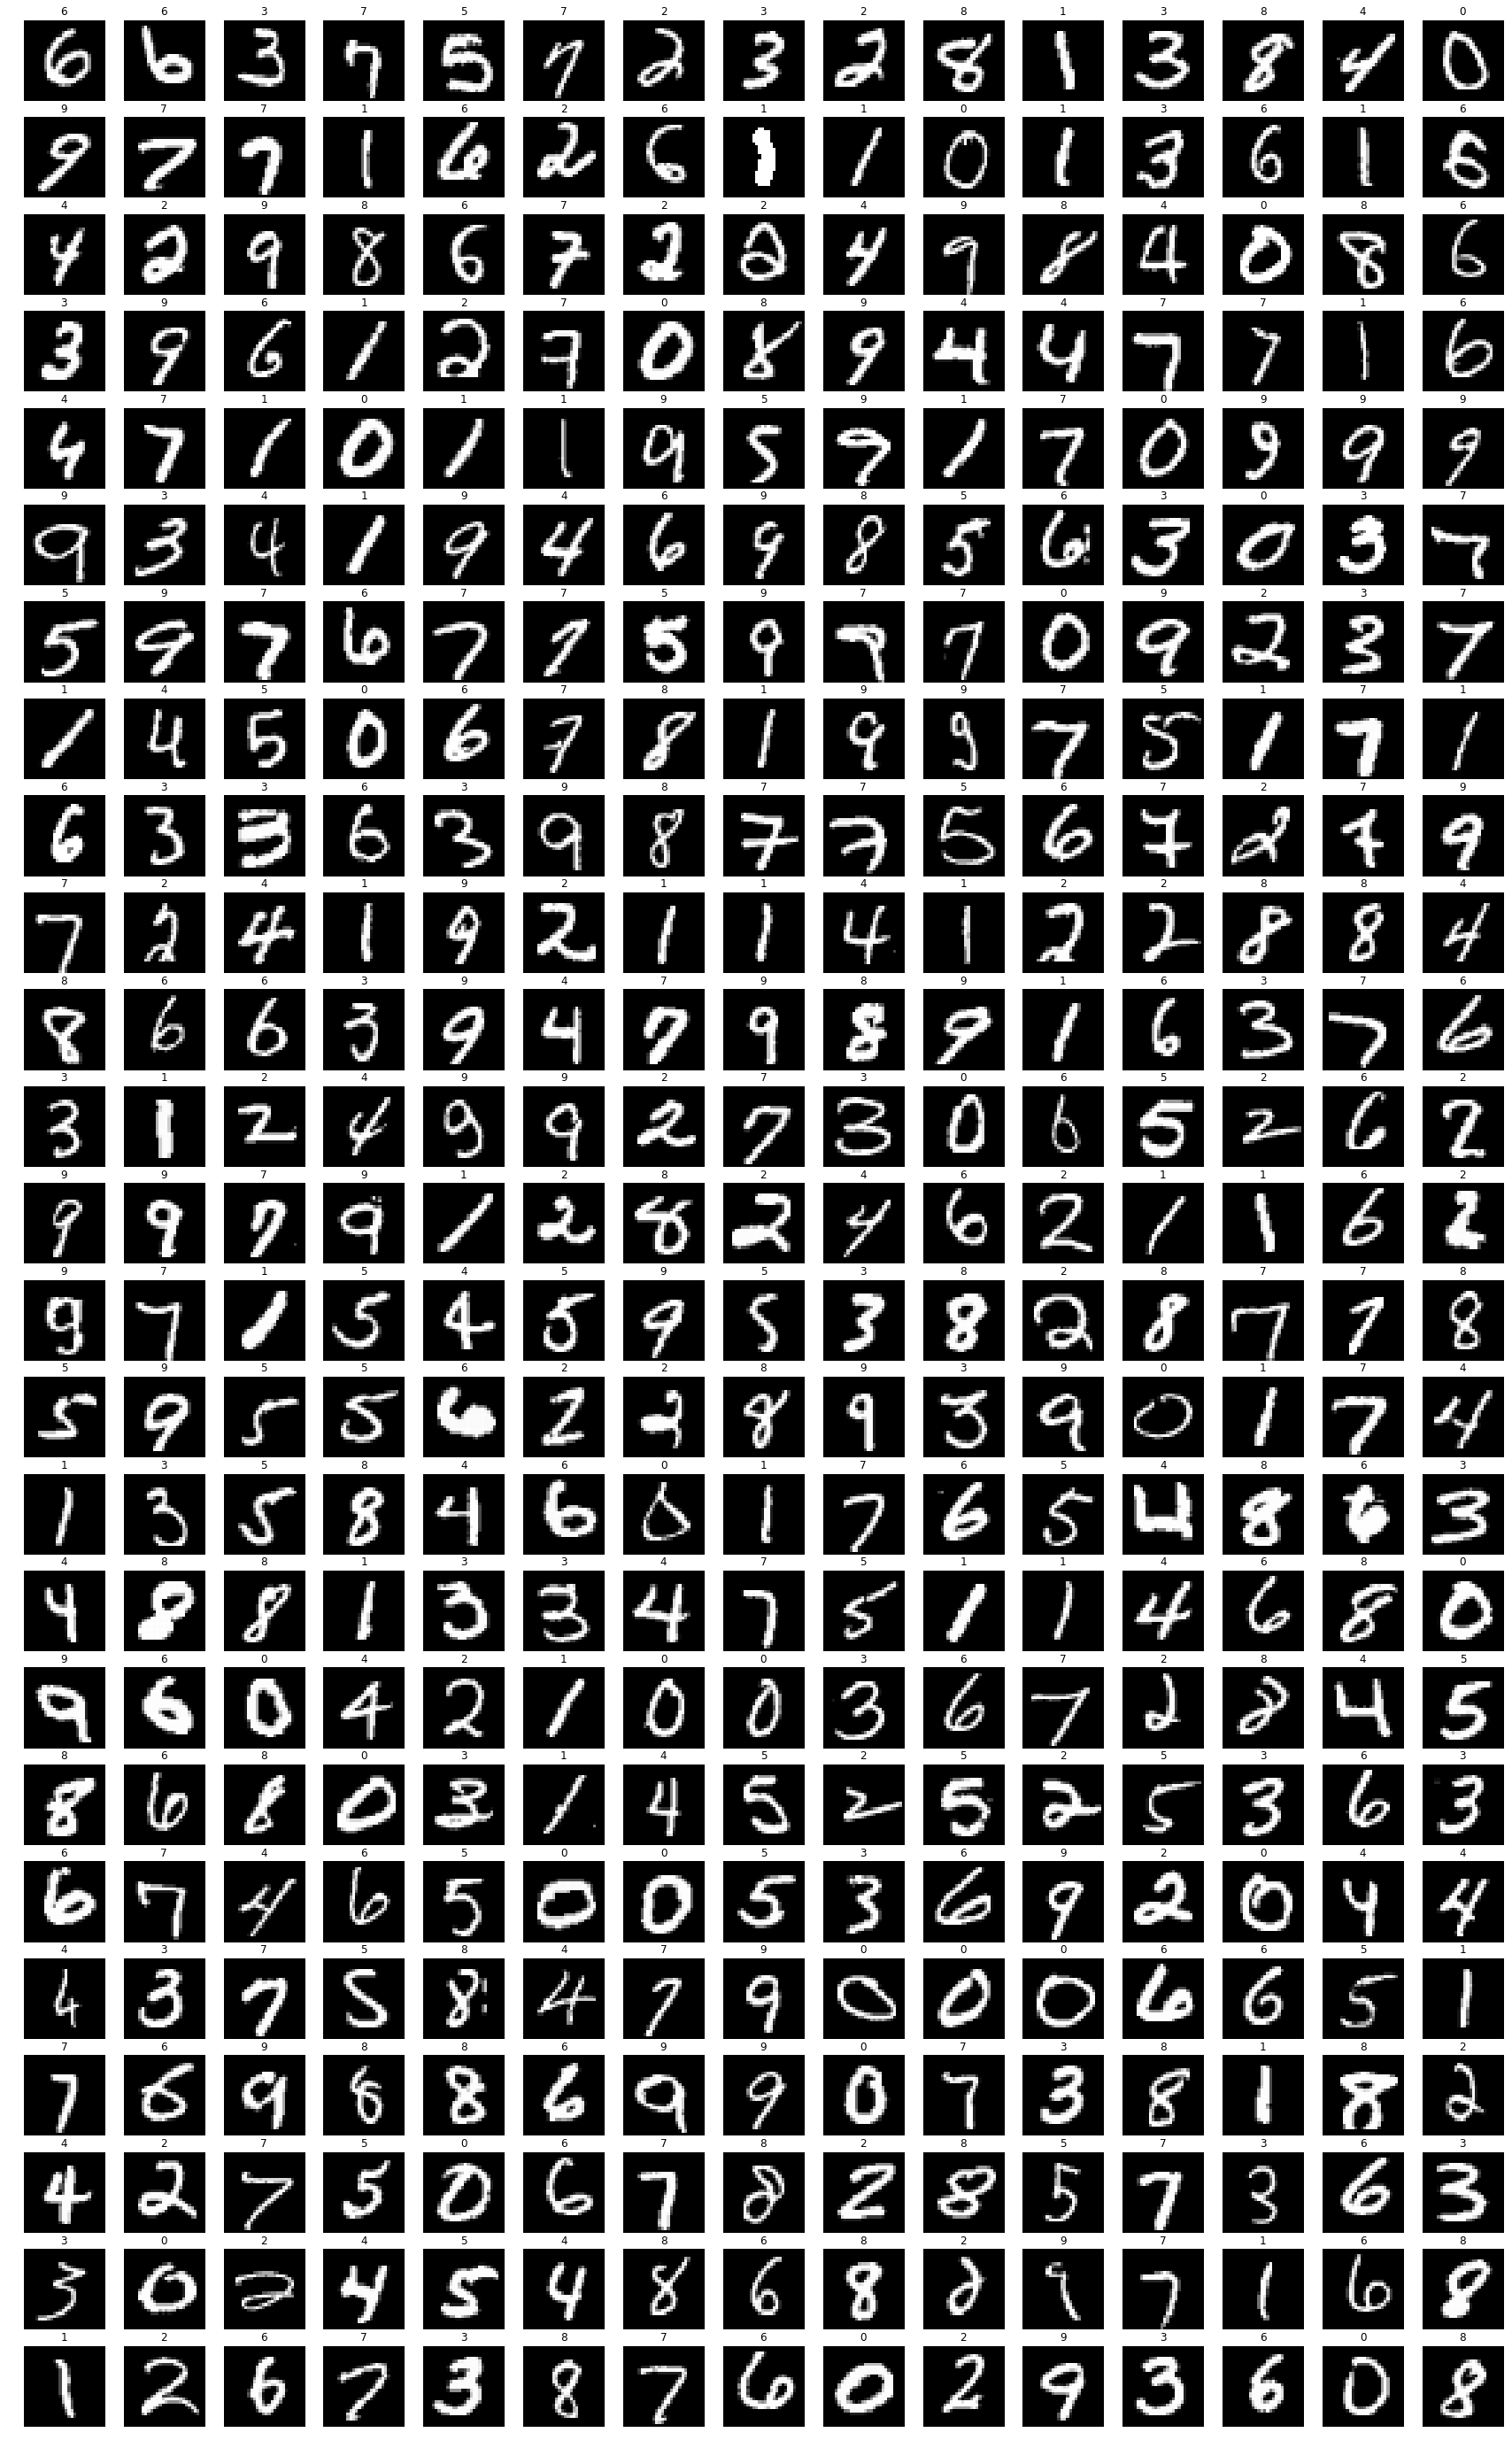

In [10]:
indices = np.random.choice(list(range(len(train_ids))), size=375)
plot_sample_image(indices, train_ids, train_labels,IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES, 0)

**Randomly generate indices and plot digits with augmentation**

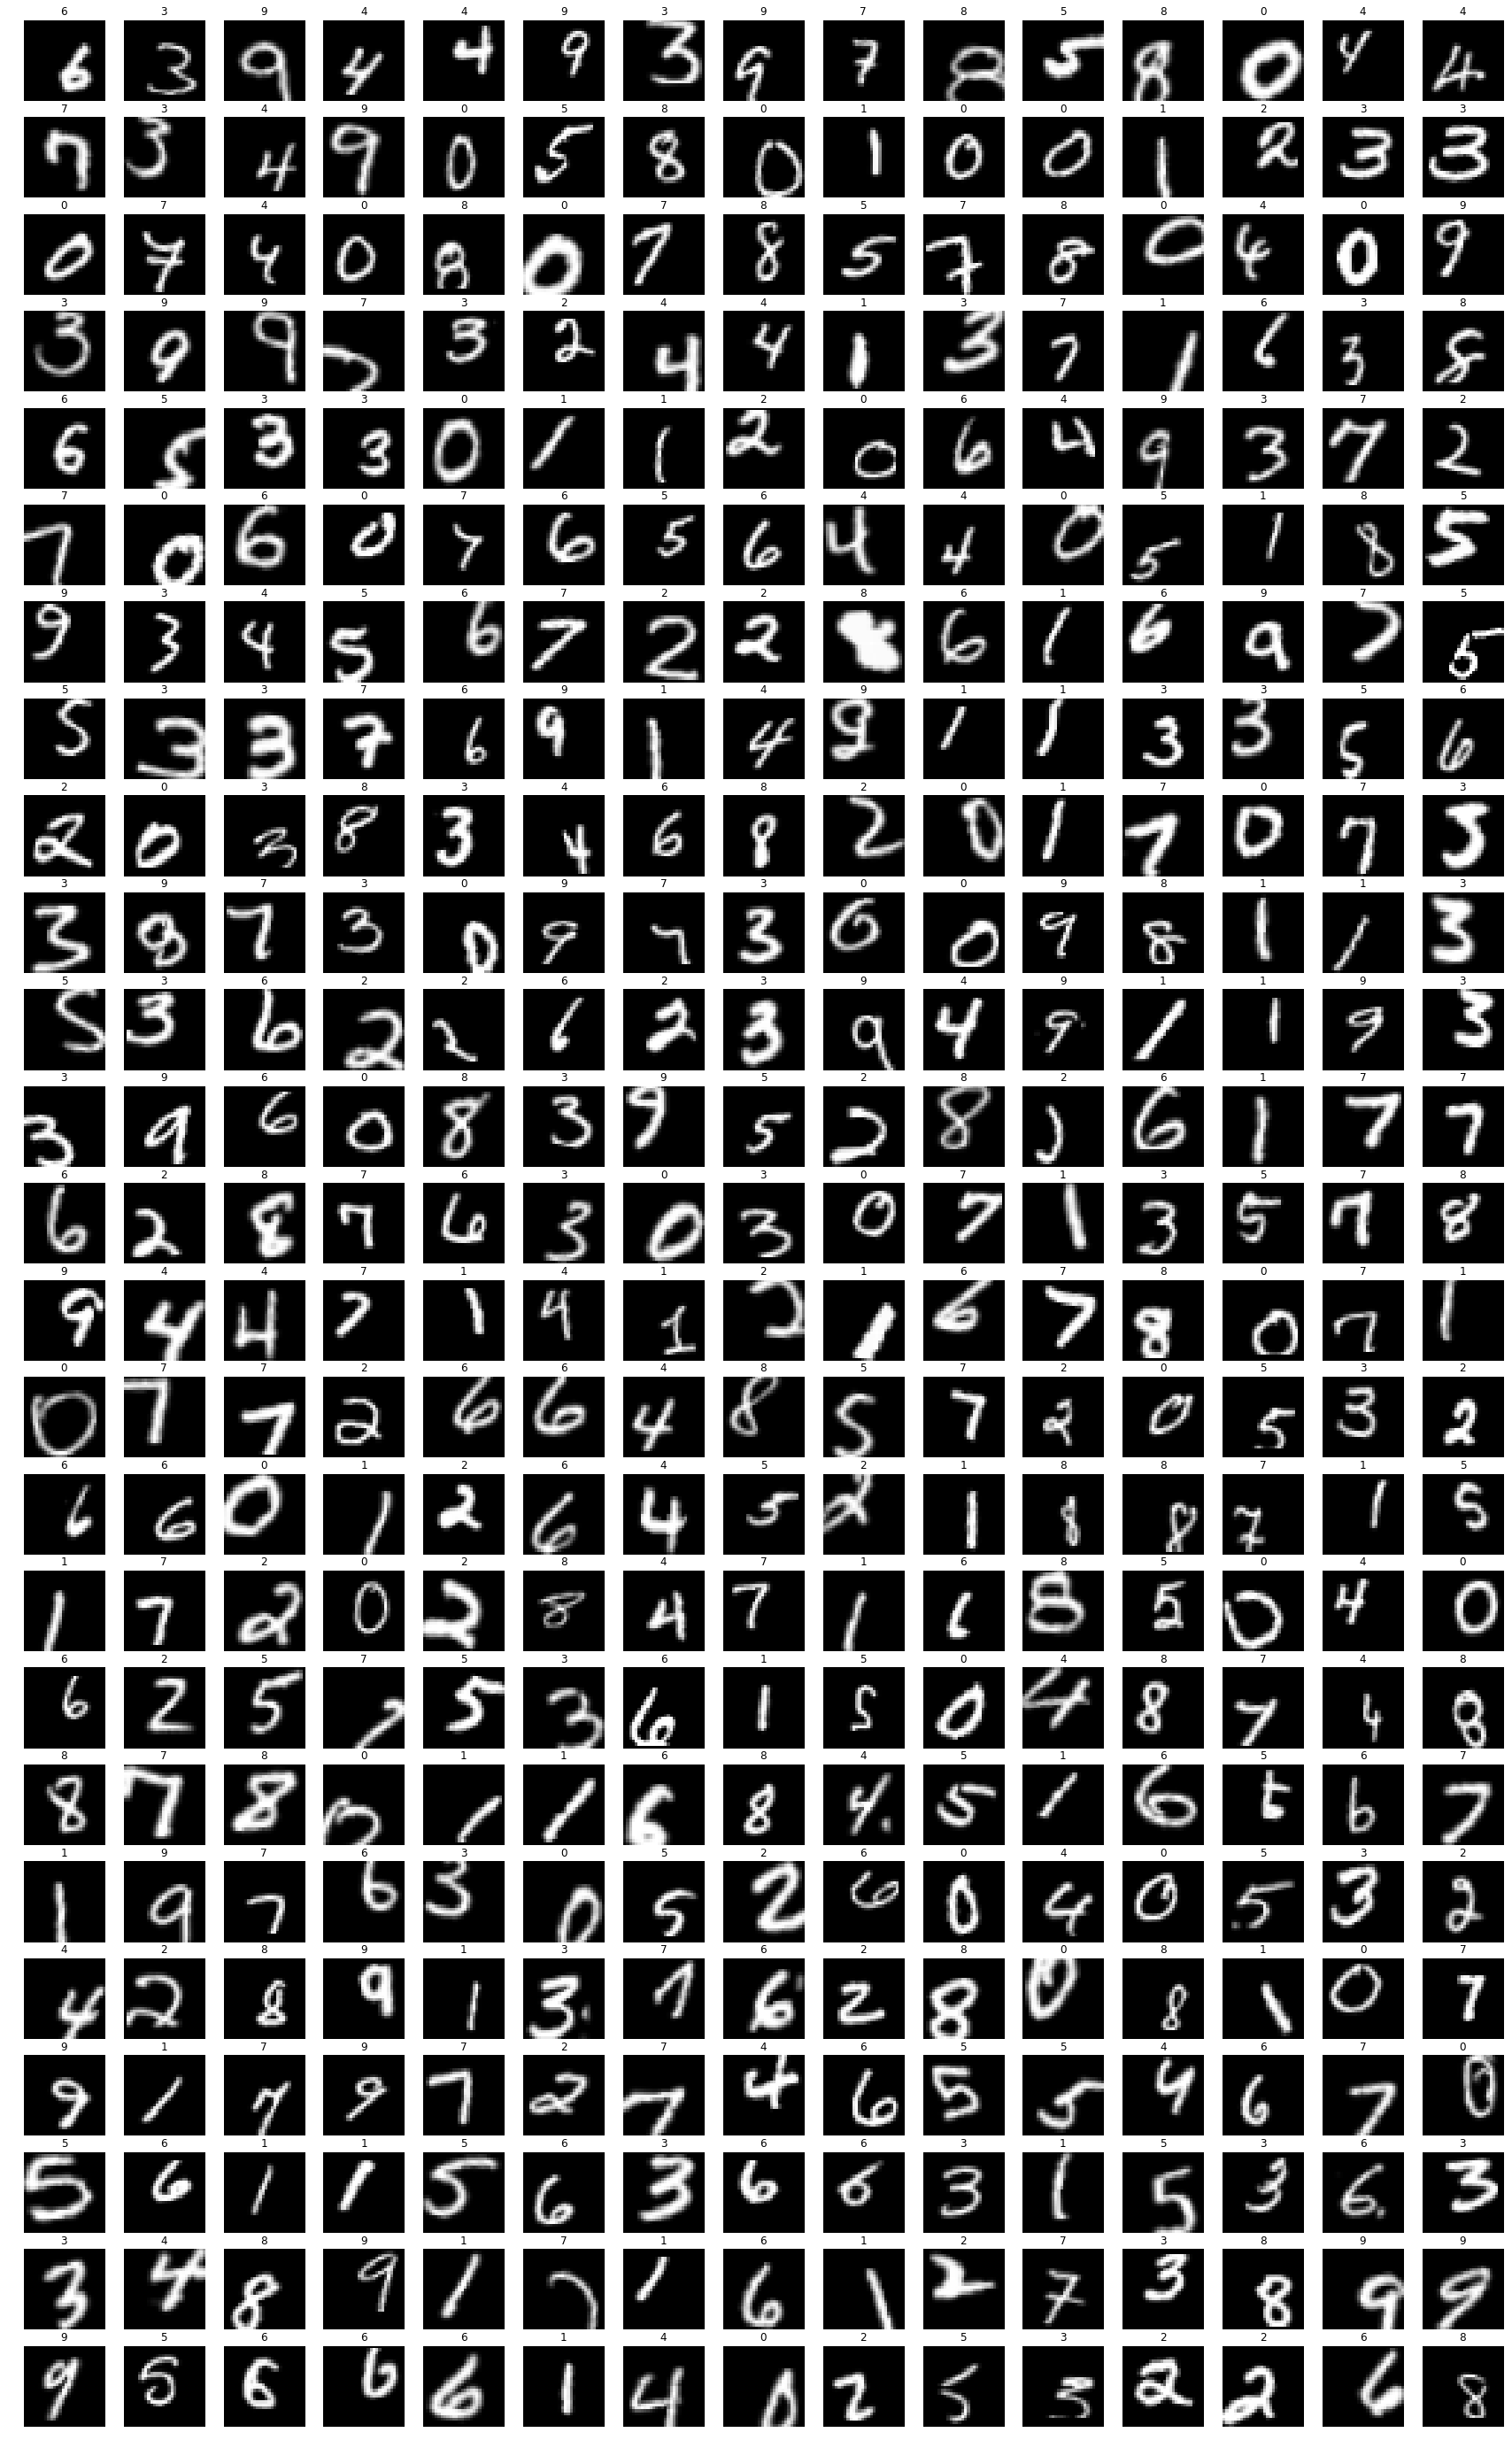

In [11]:
indices = np.random.choice(list(range(len(train_ids))), size=375)
plot_sample_image(indices, train_ids, train_labels,IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES, 1.0)

## 4. Class module of Inception Net

In [12]:
class inception(object):
    '''
    Class module of inception
    '''
    def __init__(self, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES,
                 conv_filters, dense_layers, max_pool_kernel_size, max_pool_strides,
                 learning_rate, device, tf_seed, np_seed, verbose):
        '''
        Class constructors which initializes the hyperparameters of U-Net
        '''
        # hyperparameters of the unet
        self.IMG_HEIGHT = IMG_HEIGHT
        self.IMG_WIDTH = IMG_WIDTH
        self.IMG_CHANNELS = IMG_CHANNELS
        self.N_CLASSES = N_CLASSES
        self.conv_filters = conv_filters
        self.dense_layers = dense_layers
        self.max_pool_kernel_size = max_pool_kernel_size
        self.max_pool_strides = max_pool_strides
        self.learning_rate = learning_rate
        self.device = device
        self.tf_seed = tf_seed
        self.np_seed = np_seed
        self.verbose = verbose
        
        # placeholders and operations of the U-Net
        self.X = None
        self.Y = None
        self.Y_ = None
        self.keep_prob = None
        self.training = None
        self.train_step = None
        self.cost = None
        self.accuracy = None
        
        self.X, self.Y, self.Y_, self.keep_prob , self.training, \
        self.train_step, self.cost, self.accuracy = \
        self.model()
        
        # training parameters
        self.saver = None
        self.train_cost = None
        self.valid_cost = None
        self.valid_accuracy = None
        self.best_accuracy = None
        self.best_iteration = None
        self.best_time = None
        self.log_of_computation_time = []
        
        
    def create_inception_module(self, X, num_filters):    
        '''
        A function which creates inception modules given input and number of filters
        '''
        num_filters_single_conv = num_filters//4

        with tf.device(device):
            one_by_one_1 = tf.layers.conv2d(X, filters=num_filters_single_conv, 
                                            kernel_size=1, strides=[1,1],
                                            kernel_initializer=tf.variance_scaling_initializer(),padding="SAME")

        with tf.device(device):
            three_by_three = tf.layers.conv2d(X, filters=num_filters_single_conv, 
                                              kernel_size=1, strides=[1,1],
                                              kernel_initializer=tf.variance_scaling_initializer(),
                                              padding="SAME")
            three_by_three = tf.layers.conv2d(three_by_three, filters=num_filters_single_conv, 
                                              kernel_size=3, strides=[1,1],
                                              kernel_initializer=tf.variance_scaling_initializer(),
                                              padding="SAME")

        with tf.device(device):
            five_by_five = tf.layers.conv2d(X, filters=num_filters_single_conv, 
                                            kernel_size=1, strides=[1,1],
                                            kernel_initializer=tf.variance_scaling_initializer(),
                                            padding="SAME")
            five_by_five = tf.layers.conv2d(five_by_five, filters=num_filters_single_conv, 
                                            kernel_size=5, strides=[1,1],
                                            kernel_initializer=tf.variance_scaling_initializer(),
                                            padding="SAME")

        with tf.device(device):
            one_by_one_2 = tf.layers.max_pooling2d(X, 3, 1, padding='SAME')
            one_by_one_2 = tf.layers.conv2d(one_by_one_2, filters=num_filters_single_conv, 
                                            kernel_size=1, strides=[1,1],
                                            kernel_initializer=tf.variance_scaling_initializer(),
                                            padding="SAME")

        with tf.device(device):
            conv = tf.concat((one_by_one_1, three_by_three, five_by_five, one_by_one_2), axis=3)

        return conv
    
    def model(self):
        '''
        A function to create Inception CNN Network by embedding a number of inception modules
        '''
        # placeholders for image and labels
        X = tf.placeholder(tf.float32, shape = [None, self.IMG_HEIGHT, self.IMG_WIDTH, self.IMG_CHANNELS])
        Y = tf.placeholder(tf.int32, shape = [None, self.N_CLASSES])
        # keep probability for dropout
        keep_prob = tf.placeholder(tf.float32)
        # placeholder for mode of batch normalization
        training = tf.placeholder(tf.bool)
        
        if self.verbose:
            print("####################################### CNN LAYERS #######################################")
        # iterate and create inception layers
        for n, conv_filter in enumerate(self.conv_filters):
            # first inception layer (with batch normalization)
            if n == 0:            
                conv = self.create_inception_module(X, conv_filter//2)
                if self.verbose:
                    print(conv)
                conv = tf.nn.elu(conv)
                if self.verbose:
                    print(conv)
                conv = tf.layers.batch_normalization(conv, training=training)
                if self.verbose:
                    print(conv)
                conv = self.create_inception_module(conv, conv_filter//2)
                if self.verbose:
                    print(conv)
                conv = tf.nn.elu(conv)
                if self.verbose:
                    print(conv)
                conv = tf.layers.batch_normalization(conv, training=training)
                if self.verbose:
                    print(conv)
                if self.verbose:
                    print(conv)
                conv = tf.layers.max_pooling2d(conv, self.max_pool_kernel_size, 
                                               self.max_pool_strides, padding='SAME')
                if self.verbose:
                    print(conv)
            # last inception layer (with batch normalization)
            elif n == len(conv_filters)-1:            
                conv = self.create_inception_module(conv, conv_filter//2)
                if self.verbose:
                    print(conv)
                conv = tf.nn.elu(conv)
                if self.verbose:
                    print(conv)
                conv = tf.layers.batch_normalization(conv, training=training)
                if self.verbose:
                    print(conv)
                conv = self.create_inception_module(conv, conv_filter//2)
                if self.verbose:
                    print(conv)
                conv = tf.nn.elu(conv)
                if self.verbose:
                    print(conv)
                conv = tf.layers.batch_normalization(conv, training=training)
                if self.verbose:
                    print(conv)
            # in between inception layer (with batch normalization)
            else:
                conv = self.create_inception_module(conv, conv_filter//4)
                if self.verbose:
                    print(conv)
                conv = tf.nn.elu(conv)
                if self.verbose:
                    print(conv)
                conv = tf.layers.batch_normalization(conv, training=training)
                if self.verbose:
                    print(conv)
                conv = self.create_inception_module(conv, conv_filter//4)
                if self.verbose:
                    print(conv)
                conv = tf.nn.elu(conv)
                if self.verbose:
                    print(conv)
                conv = tf.layers.batch_normalization(conv, training=training)
                if self.verbose:
                    print(conv)
                conv = tf.layers.max_pooling2d(conv, self.max_pool_kernel_size, self.max_pool_strides, padding='SAME')
                if self.verbose:
                    print(conv)

        # flatten the last layer of convolution
        with tf.device(device):
            conv_flatten = tf.layers.Flatten()(conv)
            if self.verbose:
                print(conv_flatten)

        # iterate and create the dense layer
        for n, dense_layer in enumerate(self.dense_layers):
            # first dense layer (with dropout)
            if n == 0:
                with tf.device(device):
                    dense = tf.layers.dense(conv_flatten, dense_layer,
                                            kernel_initializer=tf.variance_scaling_initializer(),
                                            activation=tf.nn.elu)
                    if self.verbose:
                        print(dense)
                    dense = tf.nn.dropout(dense, keep_prob=keep_prob)
                    if self.verbose:
                        print(dense)
             # last dense layer (without dropout)
            elif n == len(dense_layers)-1:
                with tf.device(device):
                    dense = tf.layers.dense(dense, dense_layer,
                                            kernel_initializer=tf.variance_scaling_initializer())
                    if self.verbose:
                        print(dense)
            # middle dense layers (with droput)
            else:
                with tf.device(device):
                    dense = tf.layers.dense(dense, dense_layer, 
                                            kernel_initializer=tf.variance_scaling_initializer(),
                                            activation=tf.nn.elu)
                    if self.verbose:
                        print(dense)
                    dense = tf.nn.dropout(dense, keep_prob=keep_prob)
                    if self.verbose:
                        print(dense)
                        
        if self.verbose:
            print("##########################################################################################")

        # softmax of output
        Y_pred = tf.nn.softmax(dense)
        # compute predicted class
        Y_ = tf.argmax(Y_pred, axis=1, output_type=tf.int32)
        # compute true class
        Y_true_cls = tf.argmax(Y, axis=1, output_type=tf.int32)
        # compute correct prediction
        correct_prediction = tf.equal(Y_, Y_true_cls)
        # compute accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        # cross entropy cost operation           
        with tf.device(device):
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=dense,labels=Y)
            cost = tf.reduce_mean(cross_entropy)
            
        # update operation
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        # optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        # train step
        with tf.control_dependencies(update_ops):
            with tf.device(device):
                # train step
                train_step = optimizer.minimize(cost)
        
        return X, Y, Y_, keep_prob , training, train_step, cost, accuracy
    

    def train_model(self, max_iter,batch_size, drop_prob,
                    train_indices,validation_indices,train_ids,
                    model_dir, model_name, generate_batch,augmentation_percentage,*args):
            '''
            A function to train UNET network
            '''
            # create feed dict for validation
            X_validation, Y_validation =  generate_batch(validation_indices,*args,
                                                         augmentation_percentage=0,
                                                         train_set=True, one_hot_encode=True)
            feed_dict_validation =  {self.X: X_validation.astype(np.float32), self.Y: Y_validation.astype(np.float32),
                                     self.training: False, self.keep_prob: 1.0}

            # start time
            start_time = time.time()
            # create a saver object
            saver = tf.train.Saver(max_to_keep=1)
            # lists to store the train cost, validation cost, and validation accuracy
            train_cost = []
            valid_cost = []
            valid_accuracy = [] 
            # variables to store the best cost and best iteration
            # and the time to reach the lowest cost
            best_accuracy = 0.0
            best_iteration = None
            best_time = None
            # number of training data
            N = len(train_indices)
            # number of complete batches
            num_complete_mini_batches = math.floor(N/batch_size)
            # path of model saver object
            model_path = model_dir+model_name

            # create a graph session and optimize the network under it
            with tf.Session() as sess:

                # set random seed of tensorflow
                tf.set_random_seed(self.tf_seed)
                # set random seed of numpy
                np.random.seed(self.np_seed)
                # initialize global variables
                sess.run(tf.global_variables_initializer())

                # create an object of progress bar
                bar = progressbar.ProgressBar(maxval=max_iter, widgets=[
                    '[',progressbar.Percentage(),']',
                    progressbar.Bar(),
                    '(',progressbar.DynamicMessage("train_cost"),')',
                    '(',progressbar.DynamicMessage("valid_cost"),')',
                    '(',progressbar.DynamicMessage("valid_accuracy"),')',
                    '(',progressbar.DynamicMessage("best_valid_accuracy"),')',
                    '(',progressbar.DynamicMessage("time_elapsed"),'mins)'
                ])
                # start the progress bar
                bar.start()
                # counter variable to track the number of iterations
                counter = 0
                # iterate until maximum number of iterations is reached
                while True:
                    # break out of the inner for loop if maximum number of iterations is reached
                    if counter>=max_iter:
                        break
                    # iterate through the mini batches
                    for k in range(0, num_complete_mini_batches+1):
                        # if the mini batch is a complete batch
                        if k < num_complete_mini_batches:
                            batch_indices = train_indices[list(range(k * batch_size, k * batch_size + batch_size))]
                        # handling the end case when the last mini batch is less than the batch_size
                        elif N % batch_size != 0:
                            batch_indices = train_indices[list(range(num_complete_mini_batches * batch_size, N))]

                        # conditions for flip up & down and left & right
                        conditions = np.random.choice([0,1], size=2)
                        # generate images and masks for the batch
                        X_batch, Y_batch = generate_batch(batch_indices,*args,
                                                          augmentation_percentage=augmentation_percentage,
                                                          train_set=True,
                                                          one_hot_encode=True)
                        # feed dict of the batch
                        feed_dict_batch =  {self.X: X_batch.astype(np.float32), self.Y: Y_batch.astype(np.float32),
                                            self.training: True,self.keep_prob: drop_prob}
                        # execute optimization step
                        sess.run(self.train_step, feed_dict=feed_dict_batch)
                        # calculate temporary train cost and append it to the designated list
                        temp_train_cost = self.cost.eval(session=sess, feed_dict=feed_dict_batch)
                        train_cost.append(temp_train_cost)
                        # calculate temporary validation cost and append it to the designated list
                        temp_valid_cost = self.cost.eval(session=sess, feed_dict=feed_dict_validation)
                        valid_cost.append(temp_valid_cost)
                        # calculate temporary validation accuracy and append it to the designated list
                        temp_valid_accuracy = self.accuracy.eval(session = sess, feed_dict = feed_dict_validation)
                        valid_accuracy.append(temp_valid_accuracy)
                        # compute running time from start point
                        time_diff = (time.time()-start_time)/60
                        # append elapsed time to the designated list
                        self.log_of_computation_time.append(time_diff)
                        # if valid cost is better than best recorded so far then
                        # update the parameters of the best model and save the model
                        if temp_valid_accuracy > best_accuracy:
                            best_time = time_diff
                            best_accuracy = temp_valid_accuracy
                            best_iteration = counter+1
                            saver.save(sess, model_path, global_step = best_iteration)

                        # update the progress bar
                        bar.update(counter+1, train_cost = temp_train_cost, 
                                   valid_cost = temp_valid_cost,
                                   valid_accuracy = temp_valid_accuracy, 
                                   best_valid_accuracy = best_accuracy, 
                                   time_elapsed = time_diff)
                        # increment counter variable
                        counter += 1
                        # break out of the inner for loop if maximum number of iterations is reached
                        if counter>=max_iter:
                            break
                # finish the progress bar
                bar.finish()

            # store the required variables, placeholders and operations in designated class fields
            self.saver = saver
            self.train_cost = train_cost
            self.valid_cost = valid_cost
            self.valid_accuracy = valid_accuracy
            self.best_accuracy = best_accuracy
            self.best_iteration = best_iteration
            self.best_time = best_time

    def create_predictions(self, model_path, test_ids, n_folds, submission_dir, submission_file, *args):
        '''
        A function to create predictions and submission file
        '''
        # submission path
        submission_path = submission_dir + submission_file

        with tf.Session() as sess: 
            # set random seed of tensorflow
            tf.set_random_seed(self.tf_seed)
            # restore the best model
            self.saver.restore(sess, model_path)
            # break the test set into folds other wise kernel will be out of memory
            n = len(test_ids)
            step = n//n_folds
            # array to store the prediction
            preds = np.array([])
            # create a progress bar object
            bar = progressbar.ProgressBar(maxval=n_folds, widgets=[
                            '[',progressbar.Percentage(),']',
                            progressbar.Bar(),
                            '(',progressbar.DynamicMessage("number_of_folds_completed"),')'
                        ])
            # start progress bat
            bar.start()

            # iterate through each fold
            for i in range(n_folds):
                # start and end indices of the fold
                start = (step*i)
                end = (step*(i+1))
                batch_indices = list(range(start, end))
                X = generate_batch(batch_indices,*args,augmentation_percentage=0,
                                   train_set=False, one_hot_encode=False)
                # feed dictionary for the fold
                feed_dict_test =  {self.X: X,
                                   self.keep_prob: 1.0,
                                   self.training: False}
                # evaluate predictions of the fold
                fold_preds = self.Y_.eval(session=sess, feed_dict = feed_dict_test)
                # append the predictions of the fold to the designated array
                preds = np.append(preds, fold_preds)                
                # update the progress bar
                bar.update(i+1, number_of_folds_completed = i+1)
                
            # finish the progress bar
            bar.finish()    

            # convert the prediction vector to int
            preds = preds.astype(np.int)
            # save the submission csv file
            submission = pd.DataFrame({"ImageId": test_ids, "Label": preds})
            submission.to_csv(submission_path, header = True, index=False)

## 5. Create graph of Inception net

**Inspect mounted devices**

In [13]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
print(devices)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12187443296774411186
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15864515789
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12578320301784504101
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


**If available set gpu as device**

In [14]:
if len(devices)>1:
    device = devices[-1].name
else:
    device = devices[0].name

In [15]:
tf.reset_default_graph()

**Create graph**

In [16]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES = 28,28,1,10
conv_filters = [512,1024,2048]
dense_layers = [2024,512,128,10]
max_pool_kernel_size = 2
max_pool_strides = 2
learning_rate = 0.0001
model = inception(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES,
                  conv_filters, dense_layers, max_pool_kernel_size, max_pool_strides,
                  learning_rate, device, tf_seed, np_seed, verbose = True)

####################################### CNN LAYERS #######################################
Tensor("concat:0", shape=(?, 28, 28, 256), dtype=float32, device=/device:GPU:0)
Tensor("Elu:0", shape=(?, 28, 28, 256), dtype=float32)
Tensor("batch_normalization/cond/Merge:0", shape=(?, 28, 28, 256), dtype=float32)
Tensor("concat_1:0", shape=(?, 28, 28, 256), dtype=float32, device=/device:GPU:0)
Tensor("Elu_1:0", shape=(?, 28, 28, 256), dtype=float32)
Tensor("batch_normalization_1/cond/Merge:0", shape=(?, 28, 28, 256), dtype=float32)
Tensor("batch_normalization_1/cond/Merge:0", shape=(?, 28, 28, 256), dtype=float32)
Tensor("max_pooling2d_2/MaxPool:0", shape=(?, 14, 14, 256), dtype=float32)
Tensor("concat_2:0", shape=(?, 14, 14, 256), dtype=float32, device=/device:GPU:0)
Tensor("Elu_2:0", shape=(?, 14, 14, 256), dtype=float32)
Tensor("batch_normalization_2/cond/Merge:0", shape=(?, 14, 14, 256), dtype=float32)
Tensor("concat_3:0", shape=(?, 14, 14, 256), dtype=float32, device=/device:GPU:0)
Tenso

## 6. Train Inception network

**Train network**

In [17]:
# randomly generate train and validation indices
train_indices = np.random.choice(len(train_ids), round(len(train_ids)*0.96), replace=False)
validation_indices = np.array(list(set(range(len(train_ids))) - set(train_indices)))
print("Size of train set:", len(train_indices))
print("Size of validation set:", len(validation_indices))
model_name = "inception-mnist"
max_iter = 1600
batch_size = 250
drop_prob = 0.65
augmentation_percentage = 0.667
args =(train_ids, train_labels, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES)
model.train_model(max_iter, batch_size, drop_prob, train_indices,validation_indices,
                  train_ids, model_dir, model_name, generate_batch, augmentation_percentage,*args)

Size of train set: 57600
Size of validation set: 2400


[100%]||(train_cost: 0.0264)(valid_cost: 0.0536)(valid_accuracy:  0.984)(best_valid_accuracy:  0.998)(time_elapsed:   37.3mins))


**Plot of cost vs iterations**

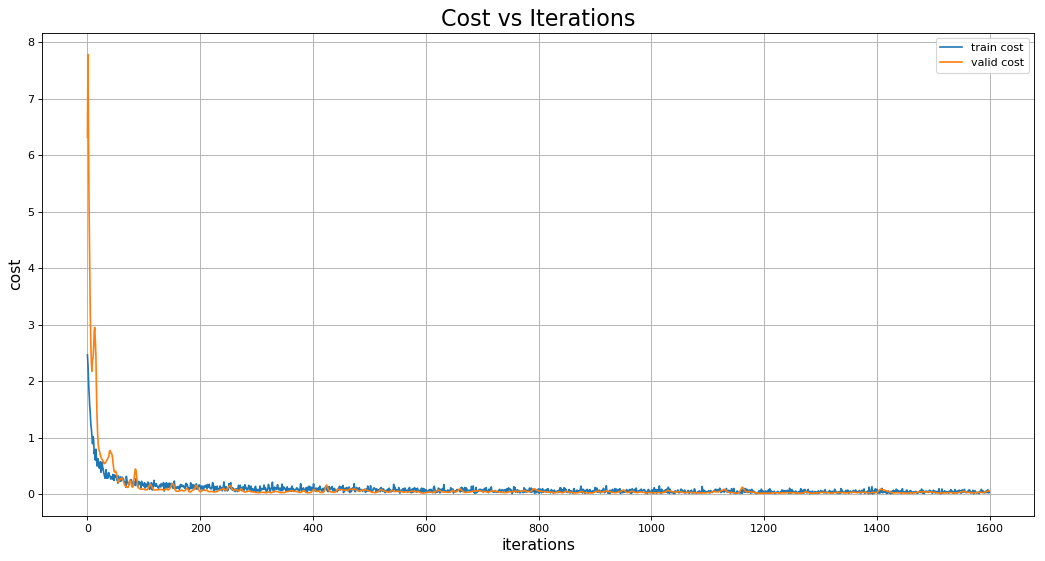

In [18]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(model.train_cost, label = 'train cost')
plt.plot(model.valid_cost, label = 'valid cost')
plt.xlabel('iterations', fontsize = 14)
plt.ylabel('cost', fontsize = 14)
plt.title("Cost vs Iterations", fontsize = 20)
plt.legend()
plt.grid()
plt.show()

**Plot of valid accuracy vs iterations**

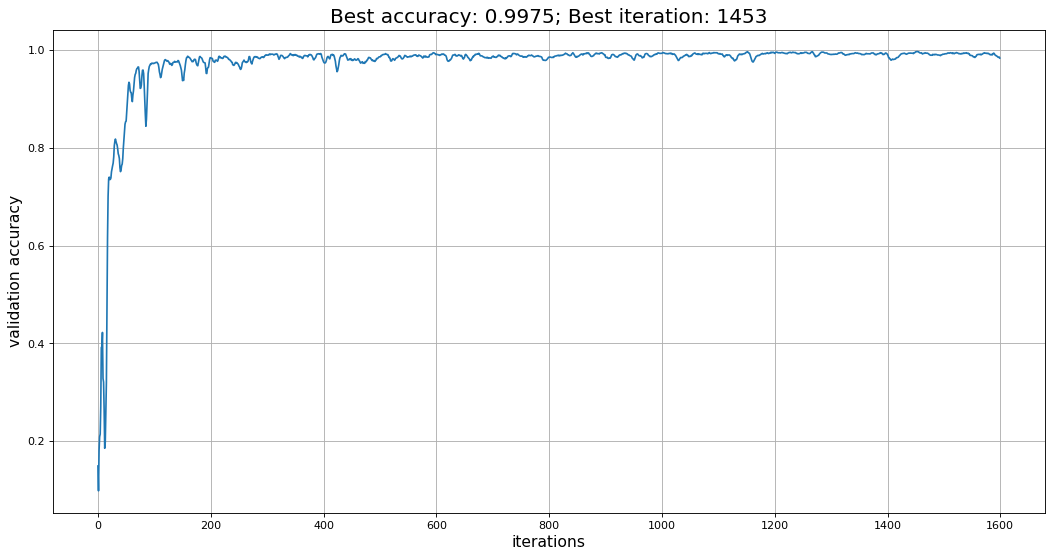

In [19]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(model.valid_accuracy, label = 'train cost')
plt.xlabel('iterations', fontsize = 14)
plt.ylabel('validation accuracy', fontsize = 14)
plt.title("Best accuracy: "+str(model.best_accuracy)+"; Best iteration: "+str(model.best_iteration),fontsize = 18)
plt.grid()
plt.show()

## 7. Analyse results

**Compute predictions of test images**

In [20]:
# restore the best model and create predictions for test data
model_path = model_dir+model_name+"-"+str(model.best_iteration)
submission_file = "submission.csv"
args =(test_ids, test_labels, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES)
n_folds = 100
model.create_predictions(model_path, test_ids, n_folds, submission_dir, submission_file, *args)

INFO:tensorflow:Restoring parameters from ./model_files/inception-mnist-1453


[100%]|####################################|(number_of_folds_completed:     99)


**Inspect submission file**

In [21]:
submission = pd.read_csv(submission_dir+"/submission.csv")

In [22]:
submission.head(30)

,ImageId,Label
0,../input/testing/3/9275.png,3
1,../input/testing/3/9561.png,3
2,../input/testing/3/505.png,3
3,../input/testing/3/213.png,3
4,../input/testing/3/894.png,3
5,../input/testing/3/4335.png,3
6,../input/testing/3/2785.png,3
7,../input/testing/3/8115.png,3
8,../input/testing/3/7365.png,3
9,../input/testing/3/4808.png,3


In [23]:
submission.tail(30)

,ImageId,Label
9970,../input/testing/9/4407.png,9
9971,../input/testing/9/4183.png,9
9972,../input/testing/9/2292.png,9
9973,../input/testing/9/62.png,9
9974,../input/testing/9/9587.png,9
9975,../input/testing/9/5705.png,9
9976,../input/testing/9/2735.png,9
9977,../input/testing/9/1058.png,9
9978,../input/testing/9/7864.png,9
9979,../input/testing/9/5757.png,9


**Print test accuracy**

In [24]:
print("Test Accuracy:", accuracy_score(test_labels, submission.Label.tolist()))

Test Accuracy: 0.9929


**Plot samples test images with corresponding predictions**

INFO:tensorflow:Restoring parameters from ./model_files/inception-mnist-1453


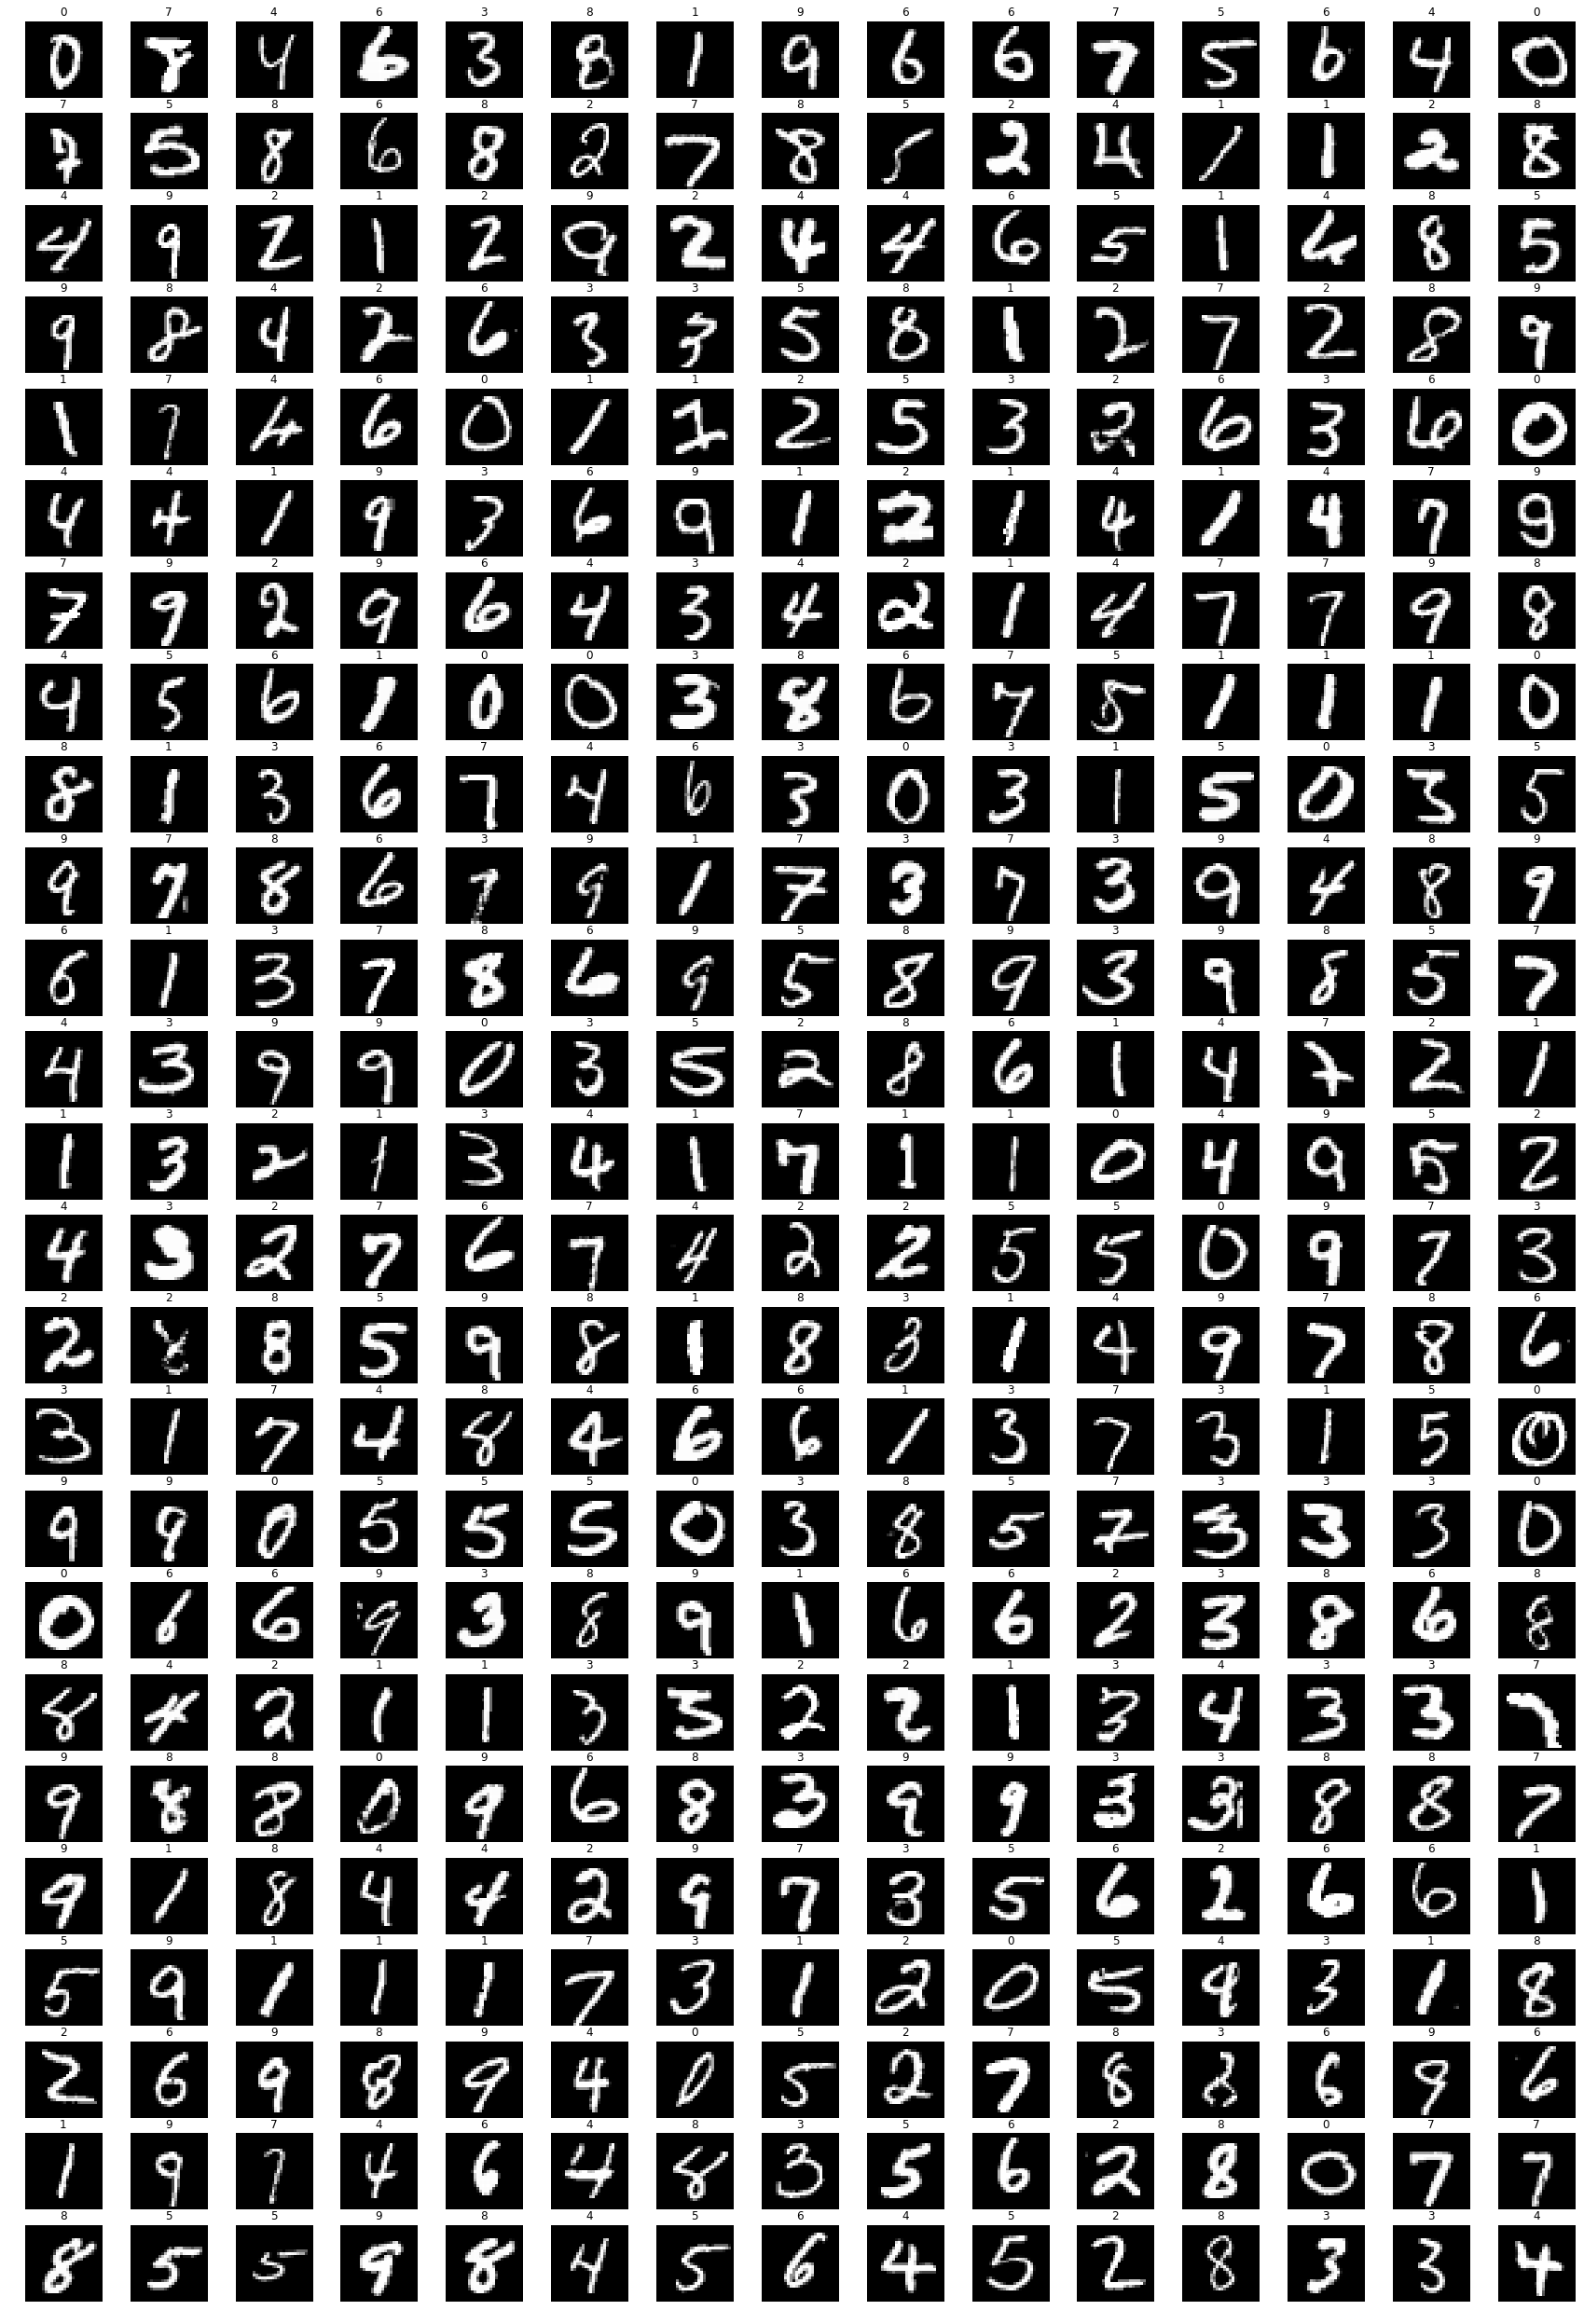

In [25]:
indices = np.random.choice(list(range(len(test_ids))), size=375)
X = generate_batch(indices, test_ids, test_labels, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES, augmentation_percentage=0)
with tf.Session() as sess:
    # restore the best model
    model.saver.restore(sess, model_path)
    feed_dict_test =  {model.X: X,
                       model.keep_prob: 1.0,
                       model.training: False}    
    preds = model.Y_.eval(session=sess, feed_dict = feed_dict_test)
    X = np.squeeze(X)
    matplotlib.rcParams['figure.figsize'] = (30.0, 45.0)
    for i in range(375):
        plt.subplot(25,15,i+1)
        plt.title(preds[i])
        plt.imshow(X[i].astype(np.int32), cmap='gray')
        plt.axis('off')
    plt.show()